In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
DATA_RAW_PATH = "../data/RAW/RT-BENE.zip" 
DATA_INTER_PATH = "../data/intermediate/"
DATA_PATH = f"{DATA_INTER_PATH}/RT-BENE"
if not os.path.exists(DATA_PATH):
    !unzip -q $DATA_RAW_PATH $DATA_INTER_PATH

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
data = pd.read_csv(f"{DATA_PATH}/blinks.csv")
data

,blink_id,left_eye,right_eye,video,blink
0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0
...,...,...,...,...,...
107345,107345,16_left_009059_rgb.png,16_right_009059_rgb.png,16,0
107346,107346,16_left_009060_rgb.png,16_right_009060_rgb.png,16,0
107347,107347,16_left_009061_rgb.png,16_right_009061_rgb.png,16,0
107348,107348,16_left_009062_rgb.png,16_right_009062_rgb.png,16,0


### How many videos do we have?

In [5]:
video_ids = np.unique(data["video"])
video_ids

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Total images

In [6]:
data["blink_id"].count()

107350

### How many images per video?

In [7]:
data_per_video = data.groupby(by=["video"]).count()
blinks_per_video = data.loc[data["blink"] == 1].groupby(by="video").count()
blinks_per_video = blinks_per_video.div(data_per_video, level="video") * 100
data_per_video = pd.concat([data_per_video["blink_id"], blinks_per_video["blink"]], axis=1, keys=["Images in video","% blink frames"])
data_per_video

,Images in video,% blink frames
video,,
0,12865,7.236689
1,8671,1.476185
2,8702,9.066881
3,3205,5.210608
4,4750,2.736842
5,5355,2.054155
7,1857,8.023694
8,6108,7.514735
9,4210,1.068884


Previous data shows that a rebalancing method will have to be used

### Create Dataset
To have a proper test partition we are going to separate the dataset in two sets of videos. One will be used for training and the other one for testing.
We will select the videos ids 13, 14, 16 as the testing videos because it's images represent around 20% of the total dataset and the percentage of blinks is similar to the rest of the dataset

#### Split train and test sets

In [8]:
testing_ids = [13,14,16]
validation_ids = [8]
training_ids = np.delete(video_ids, np.array(testing_ids)-1)
training_ids = np.delete(training_ids, np.array(validation_ids)-1)
training_ids = training_ids.tolist()
print(f"train: {training_ids}\nvalidation: {validation_ids}\ntesting: {testing_ids}")

train: [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 15]
validation: [8]
testing: [13, 14, 16]


In [9]:
train_data = data.loc[data["video"].isin(training_ids)]
print(f"train_data: {train_data.shape[0]}")
val_data = data.loc[data["video"].isin(validation_ids)]
print(f"val_data: {val_data.shape[0]}")
test_data = data.loc[data["video"].isin(testing_ids)]
print(f"test_data: {test_data.shape[0]}")

train_data: 81736
val_data: 6108
test_data: 19506


#### Generic generator class

In [47]:
import cv2
class RTBeneDataset:
    def __init__(self, phase: str, data: pd.DataFrame, mean: float, std: float, transforms = None):
        self.phase = phase
        self.data = data
        self.mean = mean
        self.std = std
        self.transforms = transforms
        self.counter = 0
        
        if self.phase == "train":
            #Shuffle the data
            self.data = self.data.sample(frac=1).reset_index(drop=True)
        else:
            self.data = self.data.reset_index(drop=True)
            
            
    def __getitem(self, idx):
        row = self.data.loc[idx,["left_eye", "right_eye"]].to_list(), self.data.loc[idx,["blink"]].to_list()[0]
        return row
    
    def __call__(self):
        for i in range(self.data.shape[0]):
            yield self.__getitem(i)
            self.counter +=1
            
            if self.counter == (self.data.shape[0] -1):
                # When all the dataset is readed, reshuffle again
                self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    @staticmethod
    @tf.function
    def tf_load_row(x, y):
        image_l = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[0]]))
        image_r = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[1]]))
        image_l = tf.image.decode_png(image_l, channels=3)
        image_r = tf.image.decode_png(image_r, channels=3)
        return (image_l, image_r), y
    
def set_shapes(imgs, label, img_shape=(36,60,3)):
        imgs[0].set_shape(img_shape)
        imgs[1].set_shape(img_shape)
        label.set_shape([])
        return imgs, label

In [71]:
train_RTB = RTBeneDataset("train", train_data, 127.5, 1)
train_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 1], 127.5, 1)
train_no_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 0], 127.5, 1)
val_RTB = RTBeneDataset("val", val_data, 127.5, 1)
test_RTB = RTBeneDataset("val", test_data, 127.5, 1)

In [49]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

In [64]:
transforms = Compose([
            #Rotate(limit=20),
            #RandomBrightness(limit=0.2),
            #JpegCompression(quality_lower=60, quality_upper=100, p=0.5),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            #RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

def scale(image, label):
    return (tf.cast(image[0], tf.float32)/255.0, tf.cast(image[1], tf.float32)/255.0), label

def process_data(image, label):
    aug_img_l = tf.numpy_function(func=aug_fn, inp=[image[0]], Tout=tf.uint8)
    aug_img_r = tf.numpy_function(func=aug_fn, inp=[image[1]], Tout=tf.uint8)
    return (aug_img_l, aug_img_r), label

In [108]:
batch_size = 128

blink_dataset = tf.data.Dataset.from_generator(train_blink_RTB, 
                                               output_types=(tf.string, tf.int32), 
                                               output_shapes=((2),()))

no_blink_dataset = tf.data.Dataset.from_generator(train_no_blink_RTB, 
                                                  output_types=(tf.string, tf.int32), 
                                                  output_shapes=((2),()))

train_dataset  = tf.data.Dataset.sample_from_datasets([blink_dataset, no_blink_dataset], [0.4, 0.6], stop_on_empty_dataset=True)\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(process_data, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size)\
    .repeat()

"""train_dataset  = tf.data.Dataset.from_generator(train_RTB, 
                                               output_types=(tf.string, tf.int32), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(process_data, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size)\
    .repeat()

"""
val_dataset = tf.data.Dataset.from_generator(val_RTB, 
                                               output_types=(tf.string, tf.int32), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(test_RTB, 
                                               output_types=(tf.string, tf.int32), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

In [109]:
it = train_dataset.as_numpy_iterator()

[1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1
 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0]


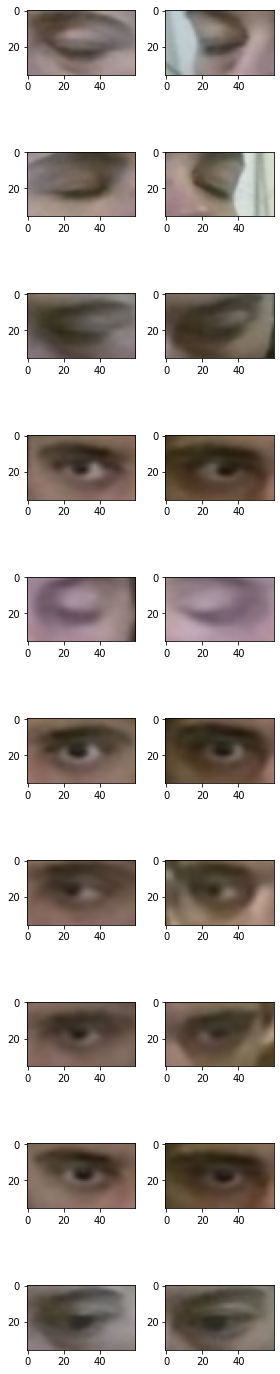

In [110]:
for data in it:
    print(data[1])
    fig,axs = plt.subplots(10,2, figsize=(4,20))
    for i in range(10):
        axs[i,0].imshow(data[0][0][i])
        axs[i,1].imshow(data[0][1][i])
    fig.tight_layout()
    break

### Create model

In [111]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16

In [112]:
left_eye = keras.Input(shape=(36, 60, 3))
right_eye = keras.Input(shape=(36, 60, 3))
vgg_left = VGG16(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
vgg_left._name = "vgg_left"
vgg_right = VGG16(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
vgg_right._name = "vgg_right"
left_feat_extractor = vgg_left(left_eye)
right_feat_extractor = vgg_right(right_eye)
concat = keras.layers.Concatenate()([left_feat_extractor, right_feat_extractor])
flat = keras.layers.Flatten()(concat)
dense_1 = keras.layers.Dense(128, activation="relu")(flat)
out = keras.layers.Dense(1, activation="sigmoid")(dense_1)

model = keras.Model(inputs=([left_eye, right_eye]), outputs=out)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 vgg_left (Functional)          (None, 1, 1, 512)    14714688    ['input_41[0][0]']               
                                                                                                  
 vgg_right (Functional)         (None, 1, 1, 512)    14714688    ['input_42[0][0]']               
                                                                                           

In [113]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), F1_score])

In [114]:
from datetime import datetime

run_id = f'{model.name}-{datetime.now().strftime("%m-%H%M%S")}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"models/{run_id}/" + "{epoch:02d}-{val_F1_score:.2f}",
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{run_id}", update_freq=100,)

history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=10, 
          steps_per_epoch=int(train_data.shape[0]/batch_size), 
          validation_steps=int(val_data.shape[0]/batch_size),
          callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
276/638 [===========>..................] - ETA: 57s - loss: 0.2759 - binary_accuracy: 0.8889 - precision_10: 0.8998 - recall_10: 0.8141 - F1_score: 0.8070

2022-02-05 16:44:39.702096: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


638/638 [==============================] - 110s 171ms/step - loss: 0.1492 - binary_accuracy: 0.9415 - precision_10: 0.9444 - recall_10: 0.9076 - F1_score: 0.9034 - val_loss: 0.2075 - val_binary_accuracy: 0.9348 - val_precision_10: 0.5551 - val_recall_10: 0.6489 - val_F1_score: 0.5843
Epoch 2/10
191/638 [=======>......................] - ETA: 1:10 - loss: 0.0423 - binary_accuracy: 0.9838 - precision_10: 0.9784 - recall_10: 0.9817 - F1_score: 0.9799

2022-02-05 16:46:15.598934: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


638/638 [==============================] - 108s 169ms/step - loss: 0.0398 - binary_accuracy: 0.9860 - precision_10: 0.9817 - recall_10: 0.9838 - F1_score: 0.9825 - val_loss: 0.5187 - val_binary_accuracy: 0.9086 - val_precision_10: 0.4381 - val_recall_10: 0.7867 - val_F1_score: 0.5574
Epoch 3/10
246/638 [==========>...................] - ETA: 1:00 - loss: 0.0260 - binary_accuracy: 0.9910 - precision_10: 0.9880 - recall_10: 0.9897 - F1_score: 0.9888

2022-02-05 16:48:11.376464: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


638/638 [==============================] - 106s 165ms/step - loss: 0.0249 - binary_accuracy: 0.9913 - precision_10: 0.9887 - recall_10: 0.9897 - F1_score: 0.9891 - val_loss: 0.6046 - val_binary_accuracy: 0.9427 - val_precision_10: 0.6284 - val_recall_10: 0.5711 - val_F1_score: 0.5840
Epoch 4/10
638/638 [==============================] - 106s 166ms/step - loss: 0.1067 - binary_accuracy: 0.9638 - precision_10: 0.9502 - recall_10: 0.9603 - F1_score: 0.9532 - val_loss: 0.1508 - val_binary_accuracy: 0.9420 - val_precision_10: 0.8217 - val_recall_10: 0.2867 - val_F1_score: 0.4106
Epoch 5/10
291/638 [============>.................] - ETA: 53s - loss: 0.0571 - binary_accuracy: 0.9813 - precision_10: 0.9752 - recall_10: 0.9781 - F1_score: 0.9766

2022-02-05 16:51:49.226269: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


638/638 [==============================] - 105s 165ms/step - loss: 0.0477 - binary_accuracy: 0.9840 - precision_10: 0.9780 - recall_10: 0.9821 - F1_score: 0.9800 - val_loss: 0.4091 - val_binary_accuracy: 0.9441 - val_precision_10: 0.9831 - val_recall_10: 0.2578 - val_F1_score: 0.3917
Epoch 6/10
638/638 [==============================] - 105s 164ms/step - loss: 0.0347 - binary_accuracy: 0.9880 - precision_10: 0.9835 - recall_10: 0.9867 - F1_score: 0.9844 - val_loss: 0.1262 - val_binary_accuracy: 0.9608 - val_precision_10: 0.7908 - val_recall_10: 0.6467 - val_F1_score: 0.7041
Epoch 7/10
638/638 [==============================] - 103s 162ms/step - loss: 0.2741 - binary_accuracy: 0.8770 - precision_10: 0.8877 - recall_10: 0.7936 - F1_score: 0.7739 - val_loss: 0.2451 - val_binary_accuracy: 0.9450 - val_precision_10: 0.7390 - val_recall_10: 0.4089 - val_F1_score: 0.4987
Epoch 8/10
638/638 [==============================] - 102s 160ms/step - loss: 0.0454 - binary_accuracy: 0.9836 - precision_

2022-02-05 16:58:58.834193: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-05 16:58:58.907866: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


638/638 [==============================] - 104s 164ms/step - loss: 0.0331 - binary_accuracy: 0.9884 - precision_10: 0.9847 - recall_10: 0.9863 - F1_score: 0.9853 - val_loss: 0.3401 - val_binary_accuracy: 0.9199 - val_precision_10: 0.4648 - val_recall_10: 0.4689 - val_F1_score: 0.4523
Epoch 10/10
638/638 [==============================] - 105s 164ms/step - loss: 0.0267 - binary_accuracy: 0.9906 - precision_10: 0.9872 - recall_10: 0.9893 - F1_score: 0.9882 - val_loss: 0.3126 - val_binary_accuracy: 0.9402 - val_precision_10: 0.5966 - val_recall_10: 0.6178 - val_F1_score: 0.5949


In [121]:
model.load_weights("models/v1_dataaug_rebalanced-02-164354/06-0.70")
results = model.evaluate(test_dataset)

153/153 [==============================] - 15s 98ms/step - loss: 0.3087 - binary_accuracy: 0.8815 - precision_10: 0.1915 - recall_10: 0.9891 - F1_score: 0.3102
